<h1>Banco de Dados - A2</h1>
<h3>Fundação Getúlio Vargas - Escola de Matemática Aplicada </br>
Bacharelado em Ciência de Dados </br>
Disciplina: Banco de Dados </br>
Professor: Renato Rocha Souza</br>
Alunos: Gianlucca Devigili e Maisa O. Fraiz</h3>

In [10]:
import sqlalchemy as sql
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import chart_studio.plotly as plotly
import plotly.graph_objects as go
from networkx_viewer import Viewer
import nx_altair as nxa
from pyvis.network import Network
import pymysql

## Importando os Dados:
Utilizamos a biblioteca pymsql para importar os dados do dataset: https://github.com/melaniewalsh/sample-social-network-datasets/tree/master/sample-datasets

Este dataset é um subset que contém todas as aparições em quadrinhos dos heróis da marvel. Ele contém 327 heróis e quase 10 mil conexões entre eles

In [11]:
conn = pymysql.connect(host='localhost', port=3306, user='root', passwd = "root")
cur = conn.cursor()
cur.execute("use marveldb")
df_nodes = pd.read_sql("SELECT * FROM heroes;", conn)
df_edges = pd.read_sql("SELECT * FROM edges;", conn)

Os dados estão em duas tabelas:
Heroes, que contém o Id ou nome do herói

In [12]:
df_nodes.head()

Id                    Label
0   Black Panther / T'chal   Black Panther / T'chal
1         Loki [asgardian]         Loki [asgardian]
2     Richards, Franklin B        Mantis / ? Brandt
3    Iceman / Robert Bobby    Iceman / Robert Bobby
4  Marvel Girl / Jean Grey  Marvel Girl / Jean Grey

E edges, que contém todas as conexões de cada herói, ou seja, indica quais heróis apareceram nos mesmos quadrinhos

In [13]:
df_edges.head()

Source                   Target  Weight
0  Black Panther / T'chal         Loki [asgardian]      10
1  Black Panther / T'chal        Mantis / ? Brandt      23
2  Black Panther / T'chal    Iceman / Robert Bobby      12
3  Black Panther / T'chal  Marvel Girl / Jean Grey      10
4  Black Panther / T'chal   Cyclops / Scott Summer      14

## Criação do Grafo com Networkx
Segue abaixo o código comentado que cria o grafo do networkx

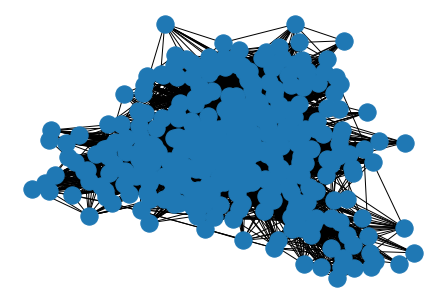

In [14]:
G = nx.Graph()
#Adiciona os nós
for i, r in df_nodes.iterrows():
    G.add_node(r["Id"])

#Faz uma tupla com as arestas
edges_tuple = [(r["Source"], r["Target"]) for i, r in df_edges.iterrows()]
#Adiciona as arestas
G.add_edges_from(edges_tuple)
nx.draw(G)

Por termos usado as configurações default do networkx.draw(), o grafo ficou estéticamente ruim, então mudamos um pouco as opções de visualização:

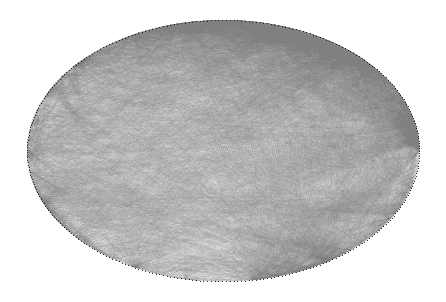

In [15]:
options = {
    "node_color": "black",
    "node_size": 1,
    "edge_color": "gray",
    "linewidths": 0,
    "width": 0.04,
}
nx.draw_circular(G, **options)

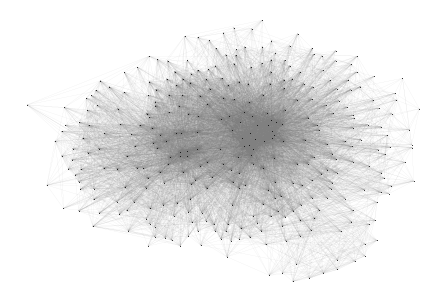

In [16]:
nx.draw_kamada_kawai(G, **options)

## Pyviz.Network
Contudo, o volume de dados ser grande, mesmo os grafo estando estéticamente bonito, ele não é capaz de dizer nada.

Portanto utilizamos a ferramenta Pyviz.network para gerar grafos interativos.
O primeiro plot é um com todos os heróis, ainda bastante carregado, então segmentamos os dados nos seguintes conjuntos:<br>
1. Heróis que aparecem em quadrinhos juntamente ao Quarteto Fantástico <br>
2. Heróis que aparecem em quadrinhos juntamente aos Avengers (primeiro filme) <br>
3. Heróis que aparecem em quadrinhos juntamente ao Professor Xavier (X-Men)

Abaixo segue o código comentado da ferramenta

In [17]:
#Cria o grafo usando pyvis
marvel_net = Network(height="1250px", width="100%", bgcolor="#ffffff", font_color="black")
marvel_net.barnes_hut()

#Popula o grafo com nós e peso
sources = df_edges['Source']
targets = df_edges['Target']
weights = df_edges['Weight']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    
    marvel_net.add_node(src, src, title=src)
    marvel_net.add_node(dst, dst, title=dst)
    marvel_net.add_edge(src, dst, value=w)

neighbor_map = marvel_net.get_adj_list()

for node in marvel_net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

#Personilização do grafo
marvel_net.toggle_physics(True)
marvel_net.set_options(''' var options = {
  "nodes": {
    "font": {
      "size": 20,
      "face": "tahoma",
      "strokeWidth": 3
    },
    "shapeProperties": {
      "borderDashes": false
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "font": {
      "face": "tahoma"
    },
    "smooth": false
  },
  "interaction": {
    "hover": true,
    "keyboard": {
      "enabled": true
    },
    "multiselect": true,
    "navigationButtons": true
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -85550,
      "centralGravity": 0.2,
      "springLength": 250,
      "springConstant": 0.001
    },
    "minVelocity": 0.75,
    "timestep": 0.2
  }
}
''')

#Gerando o html
marvel_net.show("marvel.html")


In [ ]:
Os códigos seguintes são referentes a cada grafo. Os grafos foram gerados nos respectivos arquivos html

In [18]:
query = """
SELECT Source, Target, Weight
FROM edges 
WHERE Source IN ('Mr. Fantastic / Reed R', 'Invisible Woman / Sue', 'Thing / Benjamin J. Gr', 'Human Torch /  JohnnyS')
"""
df_edges = pd.read_sql(query, conn)
df_edges.head()
#IN ('Mr. Fantastic / Reed R', 'Invisible Woman / Sue', 'Thing / Benjamin J. Gr', 'Human Torch /  JohnnyS')

Source                  Target  Weight
0   Invisible Woman / Sue  Black Panther / T'chal      39
1  Thing / Benjamin J. Gr  Black Panther / T'chal      49
2  Thing / Benjamin J. Gr   Iron Man / Tony Stark     129
3   Invisible Woman / Sue   Iron Man / Tony Stark     114
4  Thing / Benjamin J. Gr  Iron Man Iv / James R.      14

In [19]:
#Cria o grafo usando pyvis
marvel_net = Network(height="1250px", width="100%", bgcolor="#ffffff", font_color="black")
marvel_net.barnes_hut()

#Popula o grafo com nós e peso
sources = df_edges['Source']
targets = df_edges['Target']
weights = df_edges['Weight']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    
    marvel_net.add_node(src, src, title=src)
    marvel_net.add_node(dst, dst, title=dst)
    marvel_net.add_edge(src, dst, value=w)

neighbor_map = marvel_net.get_adj_list()

for node in marvel_net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

#Personilização do grafo
marvel_net.toggle_physics(True)
marvel_net.set_options(''' var options = {
  "nodes": {
    "font": {
      "size": 20,
      "face": "tahoma",
      "strokeWidth": 3
    },
    "shapeProperties": {
      "borderDashes": false
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "font": {
      "face": "tahoma"
    },
    "smooth": false
  },
  "interaction": {
    "hover": true,
    "keyboard": {
      "enabled": true
    },
    "multiselect": true,
    "navigationButtons": true
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -85550,
      "centralGravity": 0.2,
      "springLength": 250,
      "springConstant": 0.001
    },
    "minVelocity": 0.75,
    "timestep": 0.2
  }
}
''')

#Gerando o html
marvel_net.show("fantastic4.html")


In [20]:
query = """
SELECT Source, Target, Weight
FROM edges
WHERE Source IN ('Captain America', 'Iron Man / Tony Stark', 'Hulk / Dr. Robert Bruce Banner', 'Black Widow / Natasha', 'Thor / Dr. Donald Blak')
"""
df_edges = pd.read_sql(query, conn)
df_edges

Source                  Target  Weight
0    Hulk / Dr. Robert Bruce Banner  Black Panther / T'chal      27
1             Iron Man / Tony Stark  Black Panther / T'chal     120
2                   Captain America  Black Panther / T'chal     131
3            Thor / Dr. Donald Blak  Black Panther / T'chal     103
4             Black Widow / Natasha  Black Panther / T'chal      44
..                              ...                     ...     ...
492           Black Widow / Natasha  Rage / Elvin Daryl Hal      21
493           Black Widow / Natasha  Binary / Carol Danvers      24
494           Black Widow / Natasha     Fury, Col. Nicholas      37
495           Black Widow / Natasha  Collector / Taneleer T      10
496           Black Widow / Natasha  Captain Marvel / Capta      10

[497 rows x 3 columns]

In [21]:
#Cria o grafo usando pyvis
marvel_net = Network(height="1250px", width="100%", bgcolor="#ffffff", font_color="black")
marvel_net.barnes_hut()

#Popula o grafo com nós e peso
sources = df_edges['Source']
targets = df_edges['Target']
weights = df_edges['Weight']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    
    marvel_net.add_node(src, src, title=src)
    marvel_net.add_node(dst, dst, title=dst)
    marvel_net.add_edge(src, dst, value=w)

neighbor_map = marvel_net.get_adj_list()

for node in marvel_net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

#Personilização do grafo
marvel_net.toggle_physics(True)
marvel_net.set_options(''' var options = {
  "nodes": {
    "font": {
      "size": 20,
      "face": "tahoma",
      "strokeWidth": 3
    },
    "shapeProperties": {
      "borderDashes": false
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "font": {
      "face": "tahoma"
    },
    "smooth": false
  },
  "interaction": {
    "hover": true,
    "keyboard": {
      "enabled": true
    },
    "multiselect": true,
    "navigationButtons": true
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -85550,
      "centralGravity": 0.2,
      "springLength": 250,
      "springConstant": 0.001
    },
    "minVelocity": 0.75,
    "timestep": 0.2
  }
}
''')

#Gerando o html
marvel_net.show("avengers.html")


In [22]:
query = """
SELECT Source, Target, Weight
FROM edges
WHERE Source = 'Professor X / Charles'
"""
df_edges = pd.read_sql(query, conn)
df_edges.head()

Source                  Target  Weight
0  Professor X / Charles  Black Panther / T'chal       9
1  Professor X / Charles    Blob / Fred J. Dukes      27
2  Professor X / Charles  Pyro / Allerdyce Johnn       7
3  Professor X / Charles               Rogue  /      131
4  Professor X / Charles  Destiny Ii / Irene Adl       8

In [23]:
#Cria o grafo usando pyvis
marvel_net = Network(height="1250px", width="100%", bgcolor="#ffffff", font_color="black")
marvel_net.barnes_hut()

#Popula o grafo com nós e peso
sources = df_edges['Source']
targets = df_edges['Target']
weights = df_edges['Weight']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    
    marvel_net.add_node(src, src, title=src)
    marvel_net.add_node(dst, dst, title=dst)
    marvel_net.add_edge(src, dst, value=w)

neighbor_map = marvel_net.get_adj_list()

for node in marvel_net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

#Personilização do grafo
marvel_net.toggle_physics(True)
marvel_net.set_options(''' var options = {
  "nodes": {
    "font": {
      "size": 20,
      "face": "tahoma",
      "strokeWidth": 3
    },
    "shapeProperties": {
      "borderDashes": false
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "font": {
      "face": "tahoma"
    },
    "smooth": false
  },
  "interaction": {
    "hover": true,
    "keyboard": {
      "enabled": true
    },
    "multiselect": true,
    "navigationButtons": true
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -85550,
      "centralGravity": 0.2,
      "springLength": 250,
      "springConstant": 0.001
    },
    "minVelocity": 0.75,
    "timestep": 0.2
  }
}
''')

#Gerando o html
marvel_net.show("charlesX.html")


## Conclusão
A ferramenta gera um grafo animado onde os nós (heróis) possuem certa "gravidade" conforme seu peso, então aqueles que possuem gravidade maior estão ao centro do grafo. Enfatizando o Capitão América que é o herói com mais conexões.
Nos subsets que selecionamos, foi possível perceber, no caso do quarteto fantástico, que ele nem sempre aparece junto e que Tocha Humana é o herói com menos conexões dentre os quatro.
No caso dos avengers, um deles sequer apareceu no subset da autora, já que ele filtrou pelos heróis com mais conexões do dataset original (que passava de 19 mil heróis e mais de 96 mil conexões). Neste grafo podemos notar que os 5 heróis possuem um número parecido de conexões.
No grafo do professor Xavier, podemos notar que as conexões mais "fortes" dele são conexões com os X-men.